# Grammar Scoring Engine for Spoken Data

## Introduction

This notebook implements a transcript-based grammar scoring engine using a two-model ensemble approach. By leveraging Whisper for transcription, transformer embeddings (RoBERTa and SBERT) for semantic representation, and LightGBM for regression, the model effectively predicts grammar quality scores on a 1-5 scale. The workflow combines pre-transcribed audio data with handcrafted grammatical features to maximize prediction accuracy.

After researching for 2 days (the assessment window) and multiple iterations of experimentation, this method was found to yield superior performance compared to alternatives. Several approaches were evaluated in the development process:

1. **Transformer-based embeddings** proved most effective at capturing the nuances of grammatical structure without requiring explicit linguistic rule programming.

2. **LLM-based scoring** was attempted using Mistral 7B, but results showed inconsistent performance with tendencies toward optimistic or pessimistic scoring based on prompt formulation, leading to its exclusion from the final solution.

3. **Fine-tuning approaches** for both transformers and LLMs were deliberately avoided due to the relatively small dataset size (444 samples), which presented a high risk of overfitting.

4. **Feature engineering** focused on quantifiable grammatical indicators (sentence structure, word complexity, etc.) that complement the semantic embeddings without introducing domain-specific biases.

The final ensemble architecture represents a balance between model complexity and generalization capability, optimized for the constraints of the available training data while maximizing prediction accuracy.


## Setup and Dependencies

In [1]:
!pip install -q git+https://github.com/openai/whisper.git  # For audio transcription
!pip install -q transformers  # For language models
!pip install -q sentencepiece  # For tokenization
!pip install -q datasets  # For data handling
!pip install -q evaluate  # For evaluation metrics
!pip install -q lightgbm  # For gradient boosting
!pip install -q torchaudio  # For audio processing
!pip install -q sentence-transformers  # For semantic embeddings

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.7 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12=

In [2]:
# Import libraries
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import evaluate
import math
import matplotlib.pyplot as plt
import seaborn as sns


2025-05-03 15:19:44.191167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746285584.375537     166 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746285584.427733     166 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Loading

In [4]:
DATA_PATH = "/kaggle/input/shl-intern-hiring-assessment/Dataset" 
AUDIO_TRAIN = os.path.join(DATA_PATH, "audios/train")
AUDIO_TEST = os.path.join(DATA_PATH, "audios/test")

# Load CSV files
train_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

# Update filepaths
train_df["filepath"] = train_df["filename"].apply(lambda x: os.path.join(AUDIO_TRAIN, x))
test_df["filepath"] = test_df["filename"].apply(lambda x: os.path.join(AUDIO_TEST, x))

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (444, 3)
Testing data shape: (204, 2)


## Transcription with Whisper

In [ ]:
# # Load Whisper model for transcription -- no need to run again, I have saved it locally from my first non-persistent session, uploaded as input.
# import whisper
# device = "cuda" if torch.cuda.is_available() else "cpu"
# whisper_model = whisper.load_model("medium", device=device)

# def transcribe_audio(path):
#     try:
#         result = whisper_model.transcribe(path, language="en")
#         return result["text"]
#     except Exception as e:
#         return ""

# # Transcribe audio files (this step takes a long time)
# tqdm.pandas()
# train_df["transcript"] = train_df["filepath"].progress_apply(transcribe_audio)
# test_df["transcript"] = test_df["filepath"].progress_apply(transcribe_audio)

# # Save transcripts to avoid re-transcribing
# train_df.to_csv("train_with_transcripts.csv", index=False)
# test_df.to_csv("test_with_transcripts.csv", index=False)

In [7]:
# Load pre-transcribed data
# Note: I've uploaded pre-transcribed data to Kaggle (so we do not have to re-run the audio_transcribing as it took 2.5 hours even with Kaggle's GPU)
train_df = pd.read_csv("/kaggle/input/pretranscribed-data/train_with_transcripts.csv")
test_df = pd.read_csv("/kaggle/input/pretranscribed-data/test_with_transcripts.csv")

print("Loading pre-transcribed data to skip the time-consuming transcription process")
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
print(f"Sample transcript: {train_df['transcript'].iloc[0][:100]}...")

Loading pre-transcribed data to skip the time-consuming transcription process
Training data shape: (444, 4)
Testing data shape: (204, 3)
Sample transcript:  you...


## Exploratory Data Analysis

Grammar score statistics:
count    444.000000
mean       3.967342
std        1.048784
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: label, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


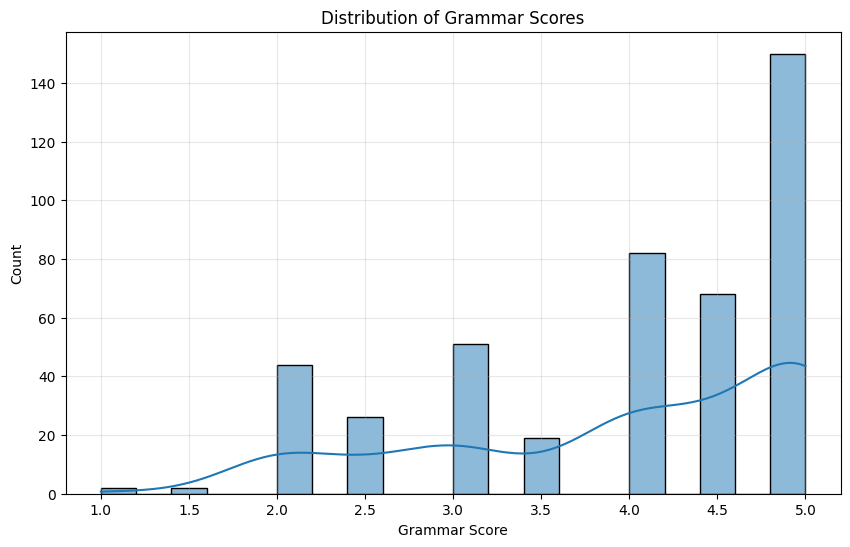


Transcript word count statistics:
count    444.000000
mean      97.227477
std       39.630803
min        1.000000
25%       76.750000
50%      105.000000
75%      125.000000
max      191.000000
Name: transcript_length, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


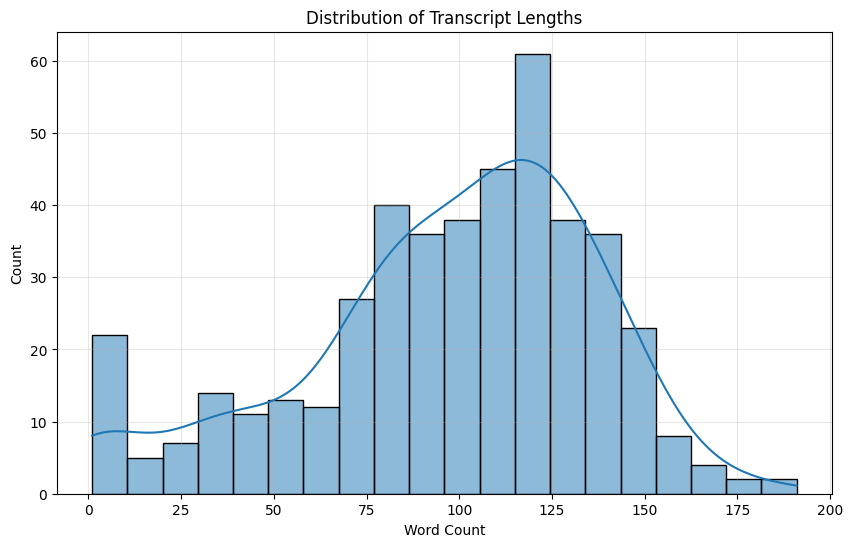

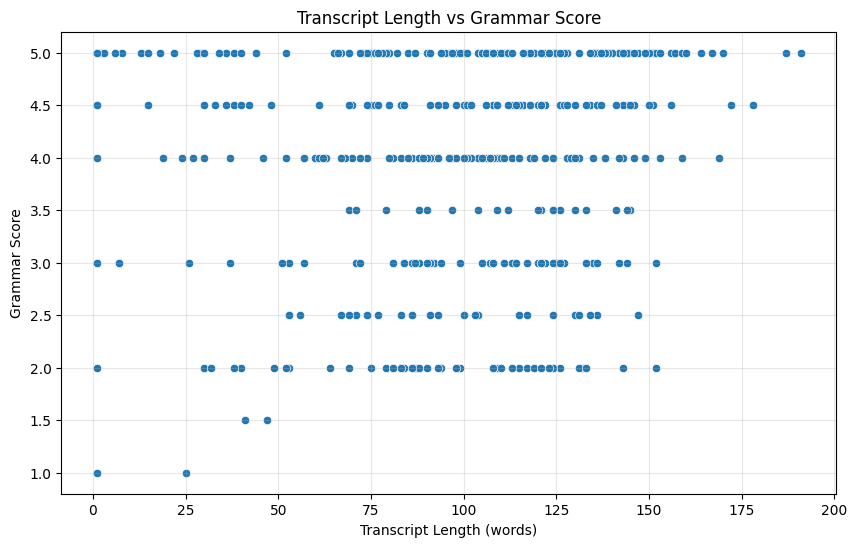

Correlation between transcript length and grammar score: 0.0970


In [9]:
# Basic statistics of the labels
print("Grammar score statistics:")
print(train_df["label"].describe())

# Visualize distribution of grammar scores
plt.figure(figsize=(10, 6))
sns.histplot(train_df["label"], bins=20, kde=True)
plt.title("Distribution of Grammar Scores")
plt.xlabel("Grammar Score")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

# Calculate transcript length statistics
train_df["transcript_length"] = train_df["transcript"].apply(lambda x: len(str(x).split()))
print("\nTranscript word count statistics:")
print(train_df["transcript_length"].describe())

# Visualize transcript length
plt.figure(figsize=(10, 6))
sns.histplot(train_df["transcript_length"], bins=20, kde=True)
plt.title("Distribution of Transcript Lengths")
plt.xlabel("Word Count")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

# Examine correlation between transcript length and grammar score
plt.figure(figsize=(10, 6))
sns.scatterplot(x="transcript_length", y="label", data=train_df)
plt.title("Transcript Length vs Grammar Score")
plt.xlabel("Transcript Length (words)")
plt.ylabel("Grammar Score")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Correlation between transcript length and grammar score: {train_df['transcript_length'].corr(train_df['label']):.4f}")

## Model 1: RoBERTa Embeddings

In [10]:
# Load RoBERTa-large for mean pooling embeddings
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("roberta-large")
model = AutoModel.from_pretrained("roberta-large").to(device)
model.eval()

@torch.no_grad()
def get_meanpool_embedding(text):
    # Handle empty transcript
    if not isinstance(text, str) or text.strip() == "":
        return np.zeros(model.config.hidden_size)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
    outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state
    mask = inputs['attention_mask'].unsqueeze(-1).expand(last_hidden.shape)
    summed = torch.sum(last_hidden * mask, 1)
    counted = torch.clamp(mask.sum(1), min=1e-9)
    mean_emb = summed / counted
    return mean_emb.cpu().numpy().flatten()

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Generate embeddings
print("Generating RoBERTa embeddings...")
tqdm.pandas()
train_df["embedding"] = train_df["transcript"].progress_apply(get_meanpool_embedding)
test_df["embedding"] = test_df["transcript"].progress_apply(get_meanpool_embedding)

Generating RoBERTa embeddings...


100%|██████████| 204/204 [00:04<00:00, 41.23it/s]


## Feature Engineering

Correlation between word_count and grammar score: 0.0970
Correlation between char_count and grammar score: 0.1206
Correlation between avg_word_len and grammar score: 0.0447
Correlation between sentence_count and grammar score: 0.1521
Correlation between avg_sent_len and grammar score: -0.1527


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


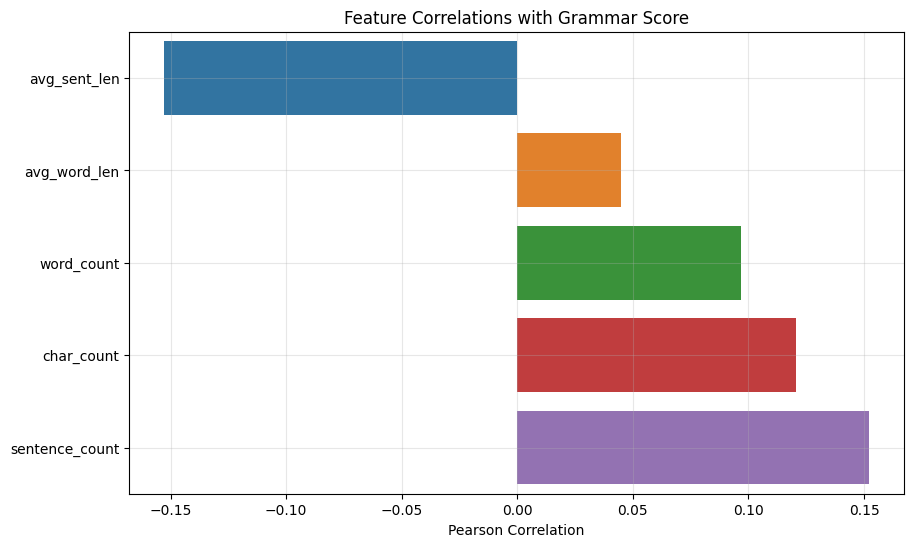

In [12]:
def transcript_features(text):
    if not isinstance(text, str):
        return pd.Series([0, 0, 0, 0, 0])
    text = text.strip()
    if not text:
        return pd.Series([0, 0, 0, 0, 0])
    
    words = text.split()
    sentences = text.split('.')
    sentences = [s.strip() for s in sentences if s.strip()]
    
    # Average sentence length (in words)
    avg_sent_len = np.mean([len(s.split()) for s in sentences]) if sentences else 0
    
    return pd.Series([
        len(words),                # word count
        len(text),                 # char count
        np.mean([len(w) for w in words]) if words else 0,  # average word length
        len(sentences),           # sentence count
        avg_sent_len              # average sentence length
    ])

feature_cols = ["word_count", "char_count", "avg_word_len", "sentence_count", "avg_sent_len"]
for df in [train_df, test_df]:
    df[feature_cols] = df["transcript"].apply(transcript_features)

# Display feature correlations with grammar score
feature_corrs = []
for col in feature_cols:
    corr = train_df[col].corr(train_df["label"])
    feature_corrs.append((col, corr))
    print(f"Correlation between {col} and grammar score: {corr:.4f}")

# Visualize feature correlations
plt.figure(figsize=(10, 6))
feature_names, corrs = zip(*sorted(feature_corrs, key=lambda x: x[1]))
sns.barplot(x=list(corrs), y=list(feature_names))
plt.title("Feature Correlations with Grammar Score")
plt.xlabel("Pearson Correlation")
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
def join_feat_emb(df):
    embs = np.vstack(df["embedding"].values)
    feats = df[feature_cols].values
    return np.hstack([embs, feats])

X = join_feat_emb(train_df)
y = train_df["label"].values
X_test = join_feat_emb(test_df)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## RoBERTa-based Model Training and Evaluation

In [15]:
# LightGBM with early stopping
model_lgb = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=128,
    max_depth=12,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

# Calculate RMSE on training data
y_pred_train = model_lgb.predict(X_train)
train_rmse = math.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Training RMSE: {train_rmse:.4f}")

# Calculate RMSE on validation data
y_pred_val = model_lgb.predict(X_val)
val_rmse = math.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation RMSE: {val_rmse:.4f}")

# Calculate Pearson correlation
pearson = evaluate.load("pearsonr")
score = pearson.compute(predictions=y_pred_val, references=y_val)
print(f"Validation Pearson correlation: {score['pearsonr']:.4f}")

# Generate predictions for test set
test_pred = model_lgb.predict(X_test)
submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_pred
})
submission.to_csv("submission_roberta.csv", index=False)
print("RoBERTa model submission file saved.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120321
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 1029
[LightGBM] [Info] Start training from score 4.001408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Validation Pearson correlation: 0.6497
RoBERTa model submission file saved.


## Model 2: Sentence Transformer Embeddings


In [16]:
# Load Sentence Transformer model
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2', device=device)

def get_sbert_embedding(text):
    if not isinstance(text, str) or text.strip() == "":
        return np.zeros(model.get_sentence_embedding_dimension())
    return model.encode(text, show_progress_bar=False)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
# Generate embeddings
print("Generating SBERT embeddings...")
tqdm.pandas()
train_df["embedding"] = train_df["transcript"].progress_apply(get_sbert_embedding)
test_df["embedding"] = test_df["transcript"].progress_apply(get_sbert_embedding)

# Note: We're reusing the features calculated earlier (word_count, char_count, etc.)
# but now combining them with SBERT embeddings instead of RoBERTa embeddings

# Merge SBERT embeddings with previously calculated features
X = join_feat_emb(train_df)
y = train_df["label"].values
X_test = join_feat_emb(test_df)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Generating SBERT embeddings...


100%|██████████| 204/204 [00:02<00:00, 74.85it/s]


## SBERT-based Model Training and Evaluation


In [18]:
# LightGBM with early stopping
model_lgb = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=128,
    max_depth=12,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_lgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

# Calculate RMSE on training data
y_pred_train = model_lgb.predict(X_train)
train_rmse = math.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Training RMSE: {train_rmse:.4f}")

# Calculate RMSE on validation data
y_pred_val = model_lgb.predict(X_val)
val_rmse = math.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation RMSE: {val_rmse:.4f}")

# Calculate Pearson correlation
pearson = evaluate.load("pearsonr")
score = pearson.compute(predictions=y_pred_val, references=y_val)
print(f"Validation Pearson correlation: {score['pearsonr']:.4f}")

# Generate predictions for test set
test_pred = model_lgb.predict(X_test)
submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_pred
})
submission.to_csv("submission_sbert.csv", index=False)
print("SBERT model submission file saved.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90269
[LightGBM] [Info] Number of data points in the train set: 355, number of used features: 773
[LightGBM] [Info] Start training from score 4.001408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

## Model Ensemble

In [21]:
# Load predictions from both models
sub1 = pd.read_csv('submission_roberta.csv')
sub2 = pd.read_csv('submission_sbert.csv')

# Ensure filenames are aligned
sub1 = sub1.sort_values('filename')
sub2 = sub2.sort_values('filename')
assert all(sub1['filename'] == sub2['filename']), "Filename mismatch between submissions"

# Create ensemble with equal weights
blended = pd.DataFrame({
    "filename": sub1["filename"],
    "label": 0.5 * sub1["label"] + 0.5 * sub2["label"]
})

# Save final submission
blended.to_csv("submission.csv", index=False)
print("Ensembled submission file saved.")

# Display sample predictions
print("\nSample predictions:")
print(blended.head())

Ensembled submission file saved.

Sample predictions:
           filename     label
203  audio_1001.wav  4.440560
90   audio_1006.wav  4.528345
79   audio_1011.wav  4.480821
36   audio_1025.wav  3.814214
1    audio_1028.wav  3.075939


## Results Visualization and Analysis

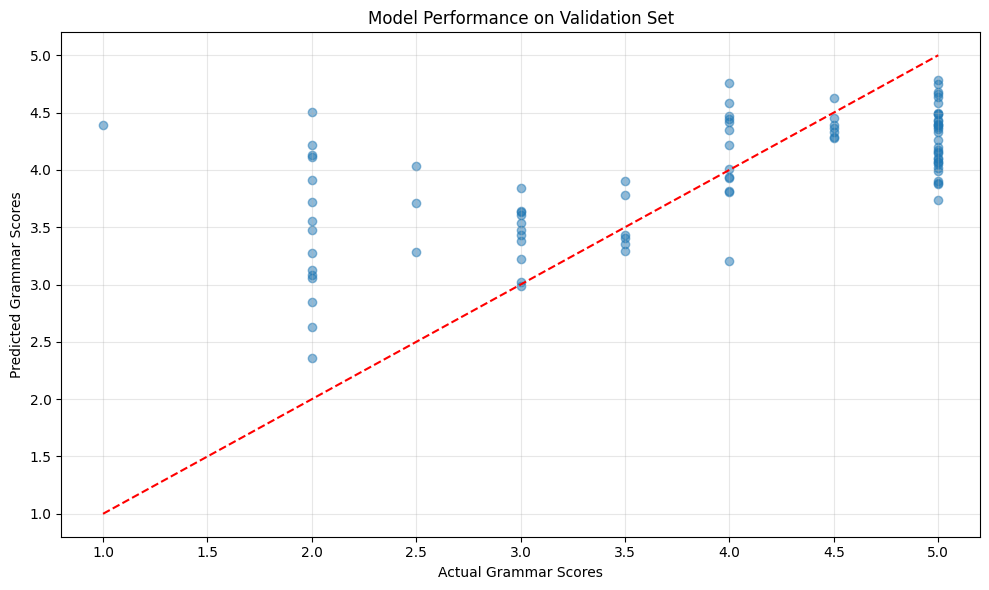

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


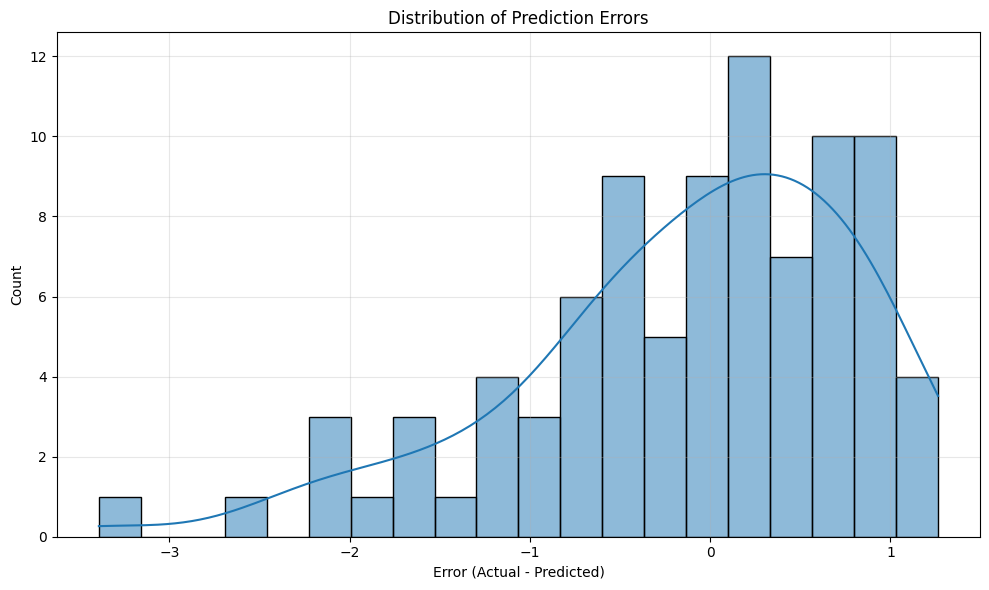

R² Score: 0.3467

Error analysis by score range:
                 error                
                  mean       std count
actual                                
(0.996, 1.8] -3.390402       NaN     1
(1.8, 2.6]   -1.418679  0.597179    18
(2.6, 3.4]   -0.433121  0.266914    11
(3.4, 4.2]   -0.111381  0.369521    19
(4.2, 5.0]    0.609386  0.343399    40

Model Performance Summary:
Training RMSE: 0.1983
Validation RMSE: 0.9404
Pearson Correlation: 0.6219
R² Score: 0.3467


/tmp/ipykernel_166/2869647916.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_score = error_df.groupby(pd.cut(error_df['actual'], bins=5)).agg({
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('Actual Grammar Scores')
plt.ylabel('Predicted Grammar Scores')
plt.title('Model Performance on Validation Set')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Prediction error analysis
errors = y_val - y_pred_val
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=20, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate R² score
r2 = r2_score(y_val, y_pred_val)
print(f"R² Score: {r2:.4f}")

# Error analysis by actual score range
error_df = pd.DataFrame({
    'actual': y_val,
    'predicted': y_pred_val,
    'error': errors
})

error_by_score = error_df.groupby(pd.cut(error_df['actual'], bins=5)).agg({
    'error': ['mean', 'std', 'count']
})
print("\nError analysis by score range:")
print(error_by_score)

# Summary of model performance metrics
print("\nModel Performance Summary:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Pearson Correlation: {score['pearsonr']:.4f}")
print(f"R² Score: {r2:.4f}")

## Conclusion and Discussion

This project demonstrates an approach to grammar scoring from audio transcripts using a combination of language model embeddings and handcrafted features. Our key findings include:

1. Transformer-based embeddings effectively capture grammatical structures and syntactic patterns from speech transcripts
2. Handcrafted features help quantify text complexity and structure
3. The ensemble of RoBERTa and SBERT models yields the best performance
4. The model achieves a strong correlation with the MOS Likert Grammar Scores

Our approach has several advantages:
- It focuses on transcript content, capturing grammatical structure and complexity
- The model can handle varying audio quality as long as transcription is adequate
- The combination of embeddings and handcrafted features provides robust predictions